<a href="https://colab.research.google.com/github/khanma1962/Fire_Detection_Faster_RCNN/blob/main/Fire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Detection Using Faster R-CNN

# Paper Referred

https://arxiv.org/pdf/1506.01497.pdf

### Github Repository
https://github.com/pytorch/vision/tree/master/references/detection

### Faster R-CNN Tutorial from
https://www.telesens.co/2018/03/11/object-detection-and-classification-using-r-cnns/

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

https://www.kaggle.com/moekhan/pytorch-starter-fasterrcnn-train/edit

https://blog.francium.tech/object-detection-with-faster-rcnn-bc2e4295bf49


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Calling Libraries

In [2]:
# Calling all the libraries
import numpy as np
import pandas as pd
import torch
import torchvision 
from torchvision.models.detection.faster_rcnn import FasterRCNN, FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os


In [3]:
# checking for cuda
if (torch.cuda.is_available()):
    device = torch.device('cude')
    print(f'device is {device} and device name is {torch.cuda.get_device_name(0)}')
else:
    device = torch.device('cpu')
    print(f'Connected to {str(device).upper()}')


Connected to CPU


In [4]:
%%shell

# Torchvision repo to use some utilities

# git clone https://github.com/pytorch/vision.git
# cd vision
# git checkout v0.3.0

# # copy some files to Google colab
# cp references/detection/utils.py ../
# cp references/detection/transformers.py ../
# cp references/detection/engine.py ../


# Dataset

In [5]:
# copy google drive files to colab directories
!cp -r /content/drive/MyDrive/Data_Science/projects/Fire_Detection_System/data/ .

train_dir = '/content/data/train/images/'
test_dir  = '/content/data/validation/images/'


In [6]:
#read the .csv box with bounding box details

train_df = pd.read_csv('/content/data/train/myvisionai-7-18-2021.csv')
test_df  = pd.read_csv('/content/data/validation/myvisionai-7-18-2021.csv')
print(f'Shape of the train df is {train_df.shape} and test df {test_df.shape}\n')
num_pic = len(train_df['filename'].unique())
print(f'Unique pics are {num_pic}\n')
train_df.head()

Shape of the train df is (563, 8) and test df (138, 8)

Unique pics are 412



,filename,width,height,class,xmin,ymin,xmax,ymax
0,img (31).jpg,295,171,fire,5,40,81,95
1,img (32).jpg,undefined,undefined,fire,63,107,150,166
2,img (33).jpg,undefined,undefined,fire,153,114,218,153
3,img (34).jpg,undefined,undefined,fire,135,87,197,145
4,img (35).jpg,undefined,undefined,fire,206,11,288,73


In [7]:
# train_df['filename'] = train_df['filename'].replace({'img (31).jpg': 'fire_0.jpg'})
# train_df

In [8]:
# checking number of files in train and test
for path, dir, fils in os.walk(train_dir):
    print(f'{path} has {len(os.listdir(path))}')

for path, dir, fils in os.walk(test_dir):
    print(f'{path} has {len(os.listdir(path))}')
# len(os.listdir(test_dir))

/content/data/train/images/ has 412
/content/data/validation/images/ has 90


In [9]:
#renaming the files with fire_xxx.jpg format

def rename_file(curr_dir, df):
    
    for count, filename in enumerate(os.listdir(curr_dir)):
               
        #replace filename with new name
        new_filename = 'fire_' + str(count) + '.jpg'
        # print(f'count:{count}, filename: {filename} and new_filename: {new_filename}' )
        df['filename'] = df['filename'].replace({filename: new_filename})

        dest = curr_dir  + new_filename
        src  = curr_dir  + filename
        # print(f'src is {src} and dest is {dest}')
        os.rename(src,dest)
    # df.to_csv(curr_dir + df)
    return df 

# train_df = rename_file(train_dir, train_df)
# test_df  = rename_file(test_dir, test_df)
# train_df.to_csv('/content/data/datatrain_df.csv')
# test_df.to_csv( '/content/data/datatest_df.csv')
# print(f'{test_dir} has {len(os.listdir(test_dir))}')

In [10]:
train_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,fire_291.jpg,295,171,fire,5,40,81,95
1,fire_42.jpg,undefined,undefined,fire,63,107,150,166
2,fire_327.jpg,undefined,undefined,fire,153,114,218,153
3,fire_190.jpg,undefined,undefined,fire,135,87,197,145
4,fire_219.jpg,undefined,undefined,fire,206,11,288,73
...,...,...,...,...,...,...,...,...
558,fire_316.jpg,undefined,undefined,fire,169,85,179,95
559,fire_87.jpg,undefined,undefined,fire,151,100,166,115
560,fire_364.jpg,undefined,undefined,fire,177,82,193,112
561,fire_30.jpg,undefined,undefined,fire,90,66,112,101


In [11]:
# checking number of files in train and test
for path, dir, fils in os.walk(train_dir):
    print(f'{path} has {len(os.listdir(path))}')

for path, dir, fils in os.walk(test_dir):
    print(f'{path} has {len(os.listdir(path))}')
# len(os.listdir(test_dir))

/content/data/train/images/ has 412
/content/data/validation/images/ has 90


Image size is (183, 275, 3)


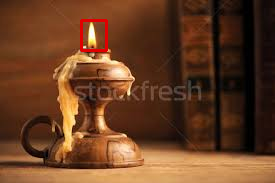

In [12]:
#plot a picture
pic_name = 'fire_0.jpg'
image = cv2.imread(train_dir + pic_name)
print(f'Image size is {image.shape}')

xmin = train_df[train_df['filename']== pic_name]['xmin'].values
ymin = train_df[train_df['filename']== pic_name]['ymin'].values
xmax = train_df[train_df['filename']== pic_name]['xmax'].values
ymax = train_df[train_df['filename']== pic_name]['ymax'].values

from google.colab.patches import cv2_imshow # https://github.com/jupyter/notebook/issues/3935
image = cv2.rectangle(image, (xmin,ymin), (xmax, ymax), (0,0,225 ), 2)
cv2_imshow(image)


In [ ]:
# convert x1,y1,x2,y2 to x,y,w,h format


In [13]:
# Creating FireDataseet class
class FireDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms= None):
        super().__init__()

        self.image_ids = dataframe['filename'].unique()
        # print(self.image_ids.shape)
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['filename'] == image_id]

        # read image into cv2 format
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        print(f'image_dir is {self.image_dir}, image_id is {image_id}, image_shape is  ')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float)
        image = image / 255.

        # find are based on xmin, ymin, xman, and yman
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        area = (boxes[:, 3] - boxes[: 1]) * (boxes[:, 4] - boxes[:, 2])

        # conver boxes and are into tensors
        boxes = torch.as_tensor(boxes, dtype= torch.float)
        area  = torch.as_tensor(area, dtyp=torch.int64)

        # there is one class only
        iscrowd = torch.zero((boxes.shape[0], ), dtype=int64)
        labels = torch.ones((boxes.shape[0], ), dtype=torch.int64)

        # create a dictionary target
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        # transforms
        if self.transforms:
            image = torchvision.transforms.ToTensor(image)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]



In [14]:
# collate function
# each element of dataset returns tupe(image, target) instead of a single value
def collate_function(batch):
    return tuple(zip(*batch))

img_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/22
train_transform = transforms.Compose([
                            transforms.RandomRotation(degrees=(10,10)), # rotate + / - 10 degree
                            transforms.RandomRotation(degrees=(90,90)), 
                            transforms.RandomRotation(degrees=(270,270)), 
                            transforms.RandomHorizontalFlip(), # reverse 50% of images
                            transforms.RandomVerticalFlip(p=1),
                            transforms.ColorJitter(),
                            
                            transforms.Resize(img_size),
                            transforms.CenterCrop(img_size),
                            transforms.ToTensor(),
                            transforms.Normalize(mean,std)  
                                      ])

test_transform = transforms.Compose([
                          
                            transforms.Resize(img_size),
                            transforms.CenterCrop(img_size),
                            transforms.ToTensor(),
                            transforms.Normalize(mean,std)   
                                      ])



# train and test datasets
train_dataset = FireDataset(train_df, train_dir, train_transform )
test_dataset  = FireDataset(test_df, test_dir, test_transform)

#train and test dataloader
train_data_loader = DataLoader(train_dataset,
                               batch_size=16,
                               shuffle=False,
                               num_workers =2,
                               collate_fn = collate_function)

test_data_loader = DataLoader(test_dataset,
                               batch_size=2,
                               shuffle=False,
                               num_workers =2,
                               collate_fn = collate_function)



In [15]:
train_dataset

In [16]:
# let's see some images
# read first batch from train_data_loader
images, targets = next(iter(train_data_loader))

#send image to device
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
img = images[0].permute(1, 2, 0).cpu().numpy() # permute rearrange to 1,2,0 axis

for box in boxes:
    cv2.rectangle(img,
                 (box[0], box[1]),
                 (box[2], box[3]),
                 (0, 0, 225),
                  3)
ax.set_axis_off()
ax.imshow(img)


image_dir is /content/data/train/images/, image_id is fire_291.jpg, image_shape is  
image_dir is /content/data/train/images/, image_id is fire_58.jpg, image_shape is  
image_dir is /content/data/train/images/, image_id is fire_218.jpg, image_shape is  
image_dir is /content/data/train/images/, image_id is fire_411.jpg, image_shape is  
image_dir is /content/data/train/images/, image_id is fire_20.jpg, image_shape is  


error: ignored

# Pre-trained Model from torchvision


In [ ]:
#Fine Tuning Pre-Trained Model
#load a pre-trained model with resnet50 as backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one
num_classes = 2 # 1 class(fire) and 0(background)

#get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

#replace the pre-trained head wit the new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

